# Population Analysis

By: Tanish Kher

In [17]:

from datascience import *
import numpy as np
from statsmodels.formula.api  import *
from numpy.random import *
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 1. Trends in Global Population Metrics and Potential Correlation With Poverty Rates.

The Objective of Part 1 of this Project is to uncover factors behind a country's poverty rates. This research is incredibly useful to policymakers in order to set targets for specific population metrics in order to lower overall poverty. 
In this project, I tested whether variables such as a country's Fertility Rate, Child mortality rate, poverty total, life expectacy can explain the country's poverty percentage in a particular year.

In [18]:
population = Table.read_table('population.csv')
countries = Table.read_table('countries.csv').where('country', are.contained_in(population.group('geo').column('geo')))
poverty = Table.read_table('poverty.csv')
life_expectancy = Table.read_table('life_expectancy.csv').where('time', are.below(2021))
child_mortality = Table.read_table('child_mortality.csv').relabel(2, 'child_mortality_under_5_per_1000_born').where('time', are.below(2021))
fertility = Table.read_table('fertility.csv').where('time', are.below(2021))
poverty.show(15)

geo,time,extreme_poverty_percent_people_below_125_a_day
alb,1996,0.2
alb,2002,0.73
alb,2004,0.53
alb,2005,0.44
alb,2008,0.2
alb,2012,0.46
dza,1988,7.1
dza,1995,6.38
ago,2000,54.31
ago,2009,43.37


Here, I created a table of all of the fertility rates of countries in the latest years that they reported their poverty percentages. The following analysis seeks to find possible correlation only between a country's Poverty Percentages and its Fertility Rates.

In [19]:
def first(values):
    return values.item(0)

latest_poverty = poverty.sort('time', descending=True).group('geo', first)
latest_poverty = latest_poverty.relabeled(0, 'geo').relabeled(1, 'time').relabeled(2, 'poverty_percent') # You should *not* change this line.

poverty_and_pop = latest_poverty.join('geo', population.where('time', 2010)).drop('time_2')
recent_poverty_total = poverty_and_pop.with_column('poverty_total', np.round((poverty_and_pop.column('poverty_percent')/100)*poverty_and_pop.column('population_total')))


In [20]:
fertility_arr = make_array()
for i in np.arange(145):
    fertility_arr = np.append(fertility_arr, fertility.where('geo', recent_poverty_total.column('geo').item(i)).where('time', recent_poverty_total.column('time').item(i)).column('children_per_woman_total_fertility'))

recent_poverty_plus_fertility = recent_poverty_total.with_column('fertility', fertility_arr)
recent_poverty_plus_fertility

geo,time,poverty_percent,population_total,poverty_total,fertility
ago,2009,43.37,23356247,1.01296e+07,6.24
alb,2012,0.46,2948029,13561,1.69
arg,2011,1.41,40895751,576630,2.36
arm,2012,1.75,2877314,50353,1.73
aus,2003,1.36,22154687,301304,1.79
aut,2004,0.34,8409945,28594,1.42
aze,2008,0.31,9032465,28001,1.87
bdi,2006,81.32,8675606,7.055e+06,6.62
bel,2000,0.5,10938735,54694,1.63
ben,2012,51.61,9199254,4.74774e+06,5.25


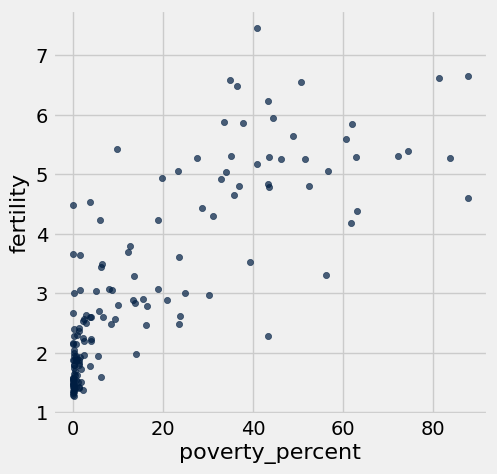

In [21]:
recent_poverty_plus_fertility.scatter('poverty_percent', 'fertility')

### Establishing Relationship between Fertility Rates and Poverty Percentage

The following is multiple regression models each aimed to most accurately represent the potential assocation between Fertility Rates and Poverty Percentage. 

#### Model 1 - Fertility vs Poverty Percent Simple Linear Regression

0.64654943654653874

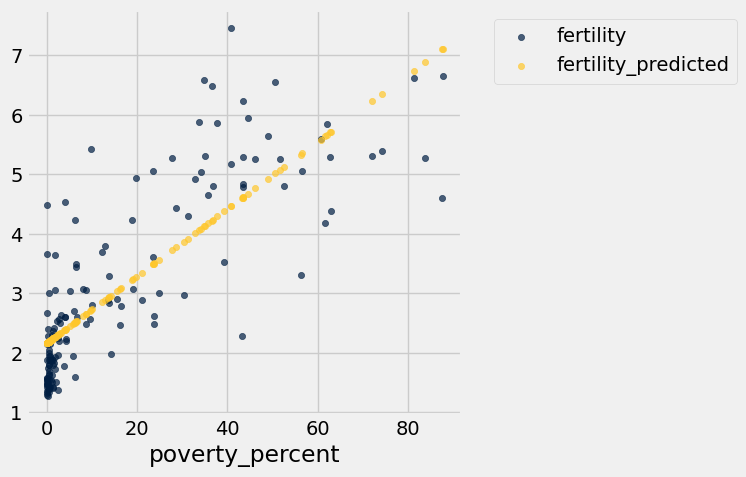

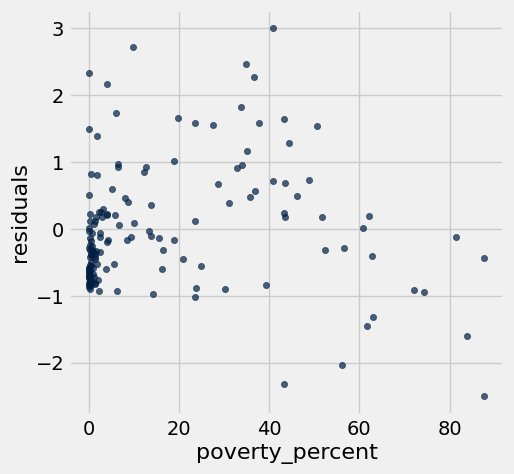

In [22]:
#fertility vs poverty_percent model
model = ols('fertility ~ poverty_percent', recent_poverty_plus_fertility).fit()
model.params


model1_table = recent_poverty_plus_fertility.with_column('fertility_predicted', model.predict(recent_poverty_plus_fertility))
model1_table.select('poverty_percent', 'fertility', 'fertility_predicted').scatter('poverty_percent')

model1_table = model1_table.with_column('residuals', model1_table.column('fertility') - model1_table.column('fertility_predicted'))
model1_table.select('poverty_percent', 'residuals').scatter('poverty_percent')
model.rsquared


#### Model 2 - Fertility vs Log(Poverty Percent) Non-Linear Regression 

This linear regression looks at the logarithmic values of poverty percent and compares it to fertility


0.56701966793474279

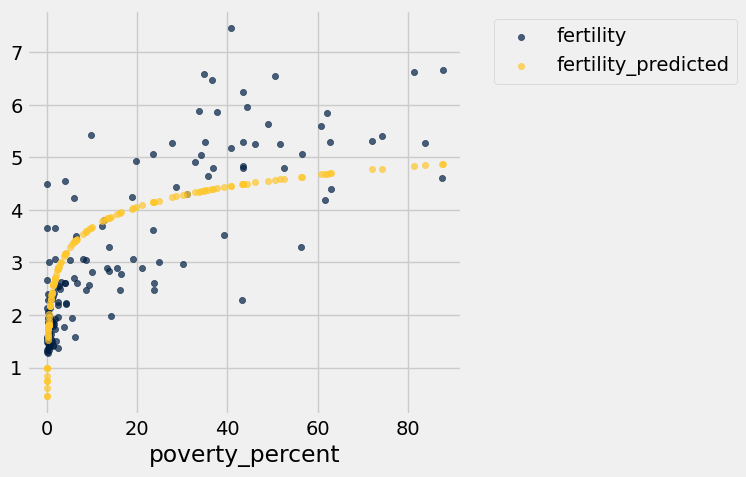

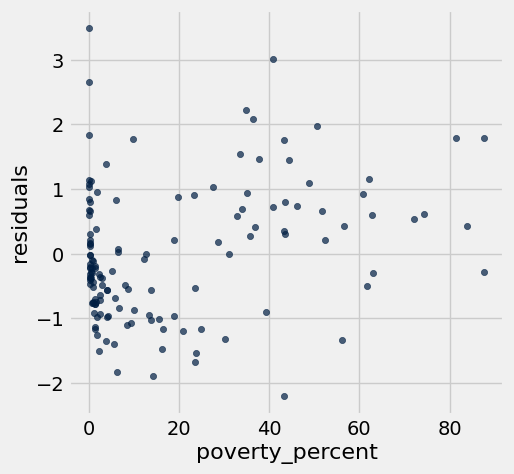

In [23]:
log_poverty_fertility = recent_poverty_plus_fertility.where('poverty_percent', are.above(0))
log_poverty_fertility = log_poverty_fertility.with_column('log_poverty_percent', np.log(log_poverty_fertility.column('poverty_percent')))
model2 = ols('fertility ~ log_poverty_percent', log_poverty_fertility).fit()

log_poverty_fertility = log_poverty_fertility.with_column('fertility_predicted', model2.predict(log_poverty_fertility))

log_poverty_fertility.select('poverty_percent', 'fertility', 'fertility_predicted').scatter('poverty_percent')

log_poverty_fertility = log_poverty_fertility.with_column('residuals', log_poverty_fertility.column('fertility') - log_poverty_fertility.column('fertility_predicted'))
log_poverty_fertility.select('poverty_percent', 'residuals').scatter('poverty_percent')
model2.rsquared



##### Model 3 - Log(Fertility) vs Log(Poverty Percent) Non-Linear Regression

To avoid any noticeable patterns in the residual plot, this representation is another logarithmic representation - this linear regression looks at the logarithmic values of poverty percent and compares it to log values of fertility


0.61666846236979822

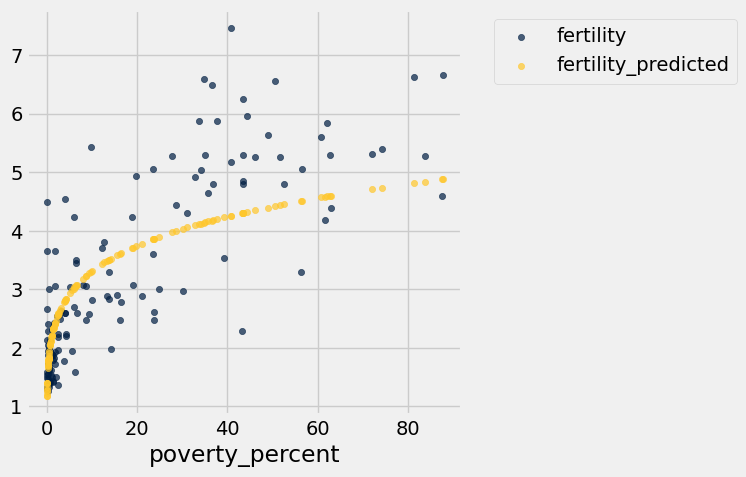

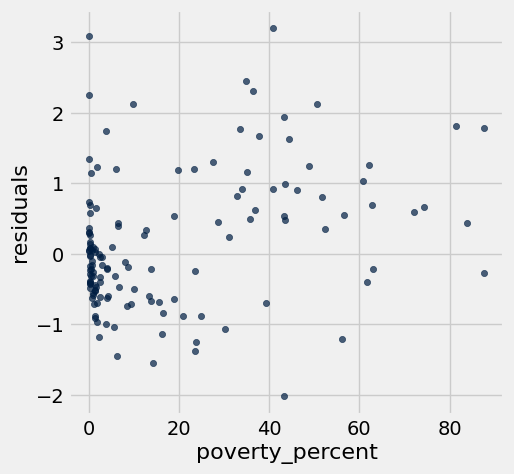

In [24]:
log_poverty_fertility_2 = recent_poverty_plus_fertility.where('poverty_percent', are.above(0))
log_poverty_fertility_2 = log_poverty_fertility_2.with_column('log_poverty_percent', np.log(log_poverty_fertility_2.column('poverty_percent')))
log_poverty_fertility_2 = log_poverty_fertility_2.with_column('log_fertility', np.log(log_poverty_fertility.column('fertility')))
model3 = ols('log_fertility ~ log_poverty_percent', log_poverty_fertility_2).fit()

log_poverty_fertility_2 = log_poverty_fertility_2.with_column('log_fertility_predicted', model3.predict(log_poverty_fertility_2))

log_poverty_fertility_2 = log_poverty_fertility_2.with_column('fertility_predicted', np.exp(log_poverty_fertility_2.column('log_fertility_predicted')))
log_poverty_fertility_2.select('poverty_percent', 'fertility', 'fertility_predicted').scatter('poverty_percent')

log_poverty_fertility_2 = log_poverty_fertility_2.with_column('residuals', log_poverty_fertility_2.column('fertility') - log_poverty_fertility_2.column('fertility_predicted'))
log_poverty_fertility_2.select('poverty_percent', 'residuals').scatter('poverty_percent')
model3.rsquared

### Using Multiple Variables to Predict Poverty Percentage

#### Model 4: Life Expectancy + Child Mortality + Fertility vs Poverty Percent Multiple Linear Regression

Because fertility rates are likely not the only factor related to a country's poverty percent, I wanted to use other variables and create the most accurate linear regression to predict a country's poverty percent. This is why I used the following variables: fertility, life expectancy, child mortality, poverty total. All of these to predict the poverty percentage. This ended up being the most accurate model, with a 74% r-squared

0.73578339004171611

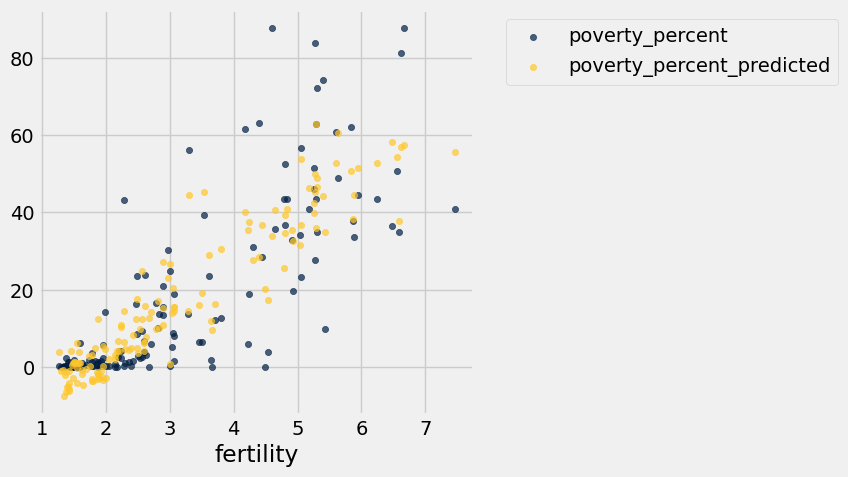

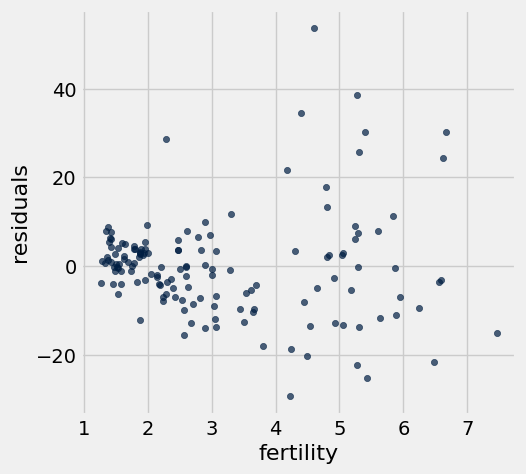

In [25]:
life_expectancy_arr = make_array()
for i in np.arange(145):
    life_expectancy_arr = np.append(life_expectancy_arr, life_expectancy.where('geo', recent_poverty_plus_fertility.column('geo').item(i)).where('time', recent_poverty_plus_fertility.column('time').item(i)).column('life_expectancy_years'))

large_table = recent_poverty_plus_fertility.with_column('life_expectancy', life_expectancy_arr)

child_mortality_arr = make_array()
for i in np.arange(145):
    child_mortality_arr = np.append(child_mortality_arr, child_mortality.where('geo', large_table.column('geo').item(i)).where('time', large_table.column('time').item(i)).column('child_mortality_under_5_per_1000_born'))

large_table = large_table.with_column('child_mortality', child_mortality_arr)
large_table

model5 = ols('poverty_percent ~ fertility + life_expectancy + child_mortality', large_table).fit()

model5_table = large_table.with_column('poverty_percent_predicted', model5.predict(large_table))
model5_table.select('poverty_percent', 'fertility', 'poverty_percent_predicted').scatter('fertility')

model5_table = model5_table.with_column('residuals', model5_table.column('poverty_percent') - model5_table.column('poverty_percent_predicted'))
model5_table.select('fertility', 'residuals').scatter('fertility')
model5.rsquared


With an R-squared value of 74%, this model is the most accurate prediction of a country's poverty percentage depending on public available data.

## Tracking Disparities in Poverty Based on Region

Part 2 of this Project analyzes poverty trends throughout the world and compares regions of the world through other metrics. This research is useful to analyze which regions of the world have been experiencing disproportionate amounts of poverty - for policymakers, this data will allow them to target funding to specific regions.

### 1. Poverty Trends

Creating a map distribution of poverty numbers throughout the world, I found that countries in South and Southeast Asia, such as India and China, have historically faced high poverty. Additionally, eastern African countries, for having small to medium populations, experience relatively high poverty totals.

In [26]:
poverty_percent = (sum(recent_poverty_total.column('poverty_total')) / sum(population.where('time', 2010).column('population_total'))*100)
poverty_percent    
countries.select('country', 'name', 'world_4region', 'latitude', 'longitude')
poverty_map = countries.select('latitude', 'longitude', 'name', 'world_4region', 'country').join('country', recent_poverty_total.select('geo', 'poverty_total'), 'geo').drop('country').relabel('world_4region', 'region')
poverty_map

colors = {'africa': 'blue', 'europe': 'black', 'asia': 'red', 'americas': 'green'}
scaled = poverty_map.with_columns(
    'labels', poverty_map.column('name'),
    'colors', poverty_map.apply(colors.get, 'region'),
    'areas', 1e-4 * poverty_map.column('poverty_total')
).drop('name', 'region', 'poverty_total')

Circle.map_table(scaled)

C:\Users\tlocal\AppData\Local\Temp\ipykernel_23940\2804813696.py:1: RuntimeWarning: overflow encountered in scalar add
  poverty_percent = (sum(recent_poverty_total.column('poverty_total')) / sum(population.where('time', 2010).column('population_total'))*100)


In [27]:
largest = poverty_map.select('name', 'poverty_total').sort('poverty_total', descending=True).take(np.arange(10))
largest.set_format('poverty_total', NumberFormatter)

def poverty_timeline(country):
    '''Draw a timeline of people living in extreme poverty in a country.'''
    # This solution will take multiple lines of code. Use as many as you need
    geo = countries.where('name', country).column('country').item(0)
    population_updated = population.where('geo', geo) 
    compiled_table = population_updated.join(['geo', 'time'], poverty, ['geo', 'time'])
    poverty_total = (compiled_table.column('extreme_poverty_percent_people_below_125_a_day')/100)*compiled_table.column('population_total')
    compiled_table = compiled_table.with_column('poverty_total', poverty_total)
    compiled_table = compiled_table.drop('geo', 'extreme_poverty_percent_people_below_125_a_day', 'population_total')
    plot = compiled_table.plot('time', 'poverty_total')
    return plot
    
    plots.title(country)
    plots.ylim(bottom=0)
    plots.show() 



all_countries = poverty_map.column('name')
_ = widgets.interact(poverty_timeline, country=list(all_countries))

interactive(children=(Dropdown(description='country', options=('Angola', 'Albania', 'Argentina', 'Armenia', 'A…

### 2. Trends in Fertility by Country

Understanding that higher fertility is linked to higher poverty rates and totals, understanding trends in fertility is critical to see if a country is trending in a positive direction in terms of prospects for poverty. The following analyzes 200+ years of data of 270+ countries to show fertility trends over time for each country.

In [28]:
from pandas import unique

def fertility_over_time(country, start):
    """Create a two-column table that describes a country's total fertility rate each year."""
    geo = countries.where('name', country).column('country').item(0)
    country_fertility = fertility.relabeled('time', 'Year').relabeled('children_per_woman_total_fertility', 'Children per woman').where('geo', geo)
    country_fertility_after_start = country_fertility.where('Year', are.above_or_equal_to(start))
    cleaned_table = country_fertility_after_start.drop('geo')
    return cleaned_table.plot(0, 1)

all_countries = poverty_map.column('name')
all_start = unique(fertility.column('time'))
_ = widgets.interact(fertility_over_time, country=list(all_countries), start=list(all_start))

interactive(children=(Dropdown(description='country', options=('Angola', 'Albania', 'Argentina', 'Armenia', 'A…

### Concluding Findings

1. Fertility rates, poverty totals, child mortality rates, and life expectancy rates are likely can relatively successfully predict the state of a countries poverty percentage for a particular year. Higher rates of fertility, child mortality rates, and life expectancy are linked to higher percentages of people in a country being in poverty. But, further classification analysis is needed to link these factors to income-tiers. 

2. Poverty totals, when analyzed regionally, show that certain regions have historic high poverty - e.g Africa and South/Southeast Asia. This is critical for institutions such as the WTO and UN to direct assistance to these specific regions

3. Fertility rates have been generally declining based on data of over 270 countries based on 200+ years of data.